In [106]:
import pandas as pd
import numpy as np

from datetime import datetime, date
from functools import reduce

In [3]:
# Need to be able to see all columns
pd.set_option('display.max_columns', 999)

In [4]:
police = pd.read_csv("./data/police_sta.csv").add_prefix("police_")
fire = pd.read_csv("./data/fire_dept.csv").add_prefix("fire_")
community = pd.read_csv("./data/community_centers.csv").add_prefix("community_")
parks = pd.read_csv("./data/parks.csv").add_prefix("parks_")
crime = pd.read_csv("./data/crime.csv", low_memory=False).add_prefix("crime_")

crime.name = "crime"
police.name = "police"
fire.name = "fire"
community.name = "community"
parks.name = "parks"

In [5]:
humidity = pd.read_csv("./data/weather/humidity.csv")
temp = pd.read_csv("./data/weather/temperature.csv")
pressure = pd.read_csv("./data/weather/pressure.csv")
weather_descript = pd.read_csv("./data/weather/weather_description.csv")
wind_dir = pd.read_csv("./data/weather/wind_direction.csv")
wind_speed = pd.read_csv("./data/weather/wind_speed.csv")

humidity.name = "humidity"
temp.name = "temperature"
pressure.name = "pressure"
weather_descript.name = "weather_description"
wind_dir.name = "wind_direction"
wind_speed.name = "wind_speed"

In [6]:
datasets = [crime, police, fire, community, parks, humidity, temp, pressure, weather_descript, wind_dir, wind_speed]

In [7]:
for df in datasets:
    # Some of the datasets have Lat/Long as Y/X, which can be confusing
    # They also have longcoord and latcoord, but they're unsigned, so dropping them
    # Regex is to avoid partial matching
    df.columns = df.columns.str.replace("^[X]", "long", regex=True)
    df.columns = df.columns.str.replace("^[Y]", "lat", regex=True)
    df.drop(list(df.filter(regex="coord")), axis = 1, inplace=True)
    
    # Makes typing easier
    df.columns = [x.lower() for x in df.columns]

In [8]:
# Renaming for consistency
crime = crime.rename({"crime_occurred_on_date":"datetime"}, axis=1)

In [9]:
crime[["crime_offense_code", "crime_offense_description"]].groupby("crime_offense_code").sum()

,crime_offense_description
crime_offense_code,
111,"MURDER, NON-NEGLIGIENT MANSLAUGHTERMURDER, NON..."
112,KILLING OF FELON BY POLICE
121,MANSLAUGHTER - VEHICLE - NEGLIGENCEMANSLAUGHTE...
123,MANSLAUGHTER - NON-VEHICLE - NEGLIGENCEMANSLAU...
301,ROBBERY - STREETROBBERY - STREETROBBERY - STRE...
...,...
3811,M/V ACCIDENT - INVOLVING BICYCLE - NO INJURYM/...
3820,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURYM/V ...
3821,M/V ACCIDENT - INVOLVING PEDESTRIAN - NO INJUR...


In [10]:
violent_list = [111, 301, 311, 315, 335, 339, 349, 351, 361, 
                371,381, 402, 403, 404, 413, 423, 432, 801, 
                802, 803, 1610, 1620, 2010, 2511, 2611]
manslaughter_list = [121, 123]
police_homicide_list = [112]
suicide_list = [3008]
drug_medical_assist_list = [1830, 1831, 1832]
removed_crimes_list = [121, 123, 670, 735, 770, 2003, 2004, 2005,
                       2900, 2905, 2906, 2907, 2910, 2914, 
                       3001, 3002, 3004, 3006, 3007] # and anything > 3008
all_other_removed_crimes_list = [x for x in crime.crime_offense_code if x > 3008]

non_violent_creation_list = violent_list + police_homicide_list + suicide_list + \
                            drug_medical_assist_list + removed_crimes_list + \
                            manslaughter_list + all_other_removed_crimes_list
# This is a set to reduce its size, as we only need one entry for each to filter against
non_violent_creation_list = set(non_violent_creation_list)

non_violent_crimes = crime.loc[~crime.crime_offense_code.isin(non_violent_creation_list)]
violent_crimes = crime.loc[crime.crime_offense_code.isin(violent_list)]
manslaughter = crime.loc[crime.crime_offense_code.isin(manslaughter_list)]
police_homicides = crime.loc[crime.crime_offense_code.isin(police_homicide_list)]
suicides = crime.loc[crime.crime_offense_code.isin(suicide_list)]
drug_medical_assists = crime.loc[crime.crime_offense_code.isin(drug_medical_assist_list)]

combined_crimes = crime.loc[~crime.crime_offense_code.isin(all_other_removed_crimes_list)]
combined_crimes = crime.loc[~crime.crime_offense_code.isin(removed_crimes_list)]

In [20]:
bos_weather = []
for df in [humidity, temp, pressure, weather_descript, wind_dir, wind_speed]:
    df = df.rename({"boston":df.name}, axis=1)
    bos_weather.append(df)

In [21]:
# Same as a SQL inner join
weather = reduce(lambda left,right: pd.merge(left,right,on=["datetime"], how="inner"), bos_weather)
weather.drop(weather.filter(regex="[Uu]nnamed"), axis=1, inplace=True)
weather.rename(columns={'boston':'weather_description'}, inplace=True)
# First row is NaN due to the join, drop it
weather.drop(weather.index[0], inplace=True)

In [22]:
weather.head()

,datetime,humidity,temperature,pressure,weather_description,wind_direction,wind_speed
1,2012-10-01 13:00:00,68.0,57.236000,1014.0,sky is clear,60.0,3.0
2,2012-10-01 14:00:00,68.0,57.264966,1014.0,few clouds,60.0,3.0
3,2012-10-01 15:00:00,68.0,57.347009,1014.0,few clouds,60.0,3.0
4,2012-10-01 16:00:00,68.0,57.429052,1014.0,few clouds,60.0,3.0
5,2012-10-01 17:00:00,68.0,57.511095,1014.0,few clouds,61.0,3.0


In [23]:
weather.describe()

,humidity,temperature,pressure,wind_direction,wind_speed
count,44804.000000,45250.000000,45246.000000,45252.000000,45252.000000
mean,77.375301,51.133681,1019.861314,184.915562,3.380889
std,18.750190,17.644498,9.548220,107.763589,2.277266
min,11.000000,-10.498000,978.000000,0.000000,0.000000
25%,65.000000,37.292000,1014.000000,80.000000,2.000000
50%,81.000000,51.769850,1019.000000,210.000000,3.000000
75%,93.000000,65.246000,1026.000000,272.000000,5.000000
max,100.000000,94.730000,1054.000000,360.000000,20.000000


In [24]:
weather.fillna(method="ffill", inplace=True)
weather.isna().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [25]:
# Need to clean up datetime a bit for the next merge

# Ensure they're in datetime64 format
crime["datetime"] = pd.to_datetime(crime["datetime"].str.replace(".", ":"))
weather["datetime"] = pd.to_datetime(weather["datetime"].str.replace(".", ":"))

# Sort by date
crime.sort_values(by="datetime", inplace=True)
weather.sort_values(by="datetime", inplace=True)

In [27]:
weather.transpose().head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,44754,44755,44756,44757,44758,44759,44760,44761,44762,44763,44764,44765,44766,44767,44768,44769,44770,44771,44772,44773,44774,44775,44776,44777,44778,44779,44780,44781,44782,44783,44784,44785,44786,44787,44788,44789,44790,44791,44792,44793,44794,44795,44796,44797,44798,44799,44800,44801,44802,44803,44804,44805,44806,44807,44808,44809,44810,44811,44812,44813,44814,44815,44816,44817,44818,44819,44820,44821,44822,44823,44824,44825,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835,44836,44837,44838,44839,44840,44841,44842,44843,44844,44845,44846,44847,44848,44849,44850,44851,44852,44853,44854,44855,44856,44857,44858,44859,44860,44861,44862,44863,44864,44865,44866,44867,44868,44869,44870,44871,44872,44873,44874,44875,44876,44877,44878,44879,44880,44881,44882,44883,44884,44885,44886,44887,44888,44889,44890,44891,44892,44893,44894,44895,44896,44897,44898,44899,44900,44901,44902,44903,44904,44905,44906,44907,44908,44909,44910,44911,44912,44913,44914,44915,44916,44917,44918,44919,44920,44921,44922,44923,44924,44925,44926,44927,44928,44929,44930,44931,44932,44933,44934,44935,44936,44937,44938,44939,44940,44941,44942,44943,44944,44945,44946,44947,44948,44949,44950,44951,44952,44953,44954,44955,44956,44957,44958,44959,44960,44961,44962,44963,44964,44965,44966,44967,44968,44969,44970,44971,44972,44973,44974,44975,44976,44977,44978,44979,44980,44981,44982,44983,44984,44985,44986,44987,44988,44989,44990,44991,44992,44993,44994,44995,44996,44997,44998,44999,45000,45001,45002,45003,45004,45005,45006,45007,45008,45009,45010,45011,45012,45013,45014,45015,45016,45017,45018,45019,45020,45021,45022,45023,45024,45025,45026,45027,45028,45029,45030,45031,45032,45033,45034,45035,45036,45037,45038,45039,45040,45041,45042,45043,45044,45045,45046,45047,45048,45049,45050,45051,45052,45053,45054,45055,45056,45057,45058,45059,45060,45061,45062,45063,45064,45065,45066,45067,45068,45069,45070,45071,45072,45073,45074,45075,45076,45077,45078,45079,45080,45081,45082,45083,45084,45085,45086,45087,45088,45089,45090,45091,45092,45093,45094,45095,45096,45097,45098,45099,45100,45101,45102,45103,45104,4

In [35]:
violent_crimes.head()

,crime_incident_number,crime_offense_code,crime_offense_code_group,crime_offense_description,crime_district,crime_reporting_area,crime_shooting,datetime,crime_year,crime_month,crime_day_of_week,crime_hour,crime_ucr_part,crime_street,crime_lat,crime_long,crime_location
6,I192078638,801,Simple Assault,ASSAULT - SIMPLE,A1,75,NaN,2019-09-29 04:46:00,2019,9,Sunday,4,Part Two,CAUSEWAY ST,42.364331,-71.063193,"(42.36433126, -71.06319318)"
19,I192078613,423,Aggravated Assault,ASSAULT - AGGRAVATED,A7,17,NaN,2019-09-29 02:30:00,2019,9,Sunday,2,Part One,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)"
20,I192078613,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,17,NaN,2019-09-29 02:30:00,2019,9,Sunday,2,Part Two,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)"
24,I192078609,301,Robbery,ROBBERY - STREET,A1,119,NaN,2019-09-29 01:01:00,2019,9,Sunday,1,Part One,TREMONT ST,42.356375,-71.062135,"(42.35637531, -71.06213513)"
25,I192078608,801,Simple Assault,ASSAULT - SIMPLE,E18,501,NaN,2019-09-29 01:35:00,2019,9,Sunday,1,Part Two,CANTERBURY ST,42.278688,-71.117344,"(42.27868789, -71.11734430)"


In [39]:
violent_crimes.groupby(['crime_year', 'crime_month']).count()['crime_incident_number']

crime_year  crime_month
2015        6              377
            7              865
            8              787
            9              774
            10             745
            11             744
            12             733
2016        1              690
            2              577
            3              733
            4              773
            5              788
            6              774
            7              766
            8              758
            9              678
            10             783
            11             708
            12             720
2017        1              730
            2              608
            3              638
            4              704
            5              773
            6              762
            7              779
            8              819
            9              784
            10             767
            11             727
            12             744
2018        1  

In [51]:
def AddContinuousDates(df):
    min_date = datetime.strptime(df['datetime'].min(), '%Y-%m-%d %H:%M:%S')
    df['days_continuous'] = [(datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - min_date).days for x in df['datetime']]

AddContinuousDates(violent_crimes)

/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
crime_min_date = datetime.strptime(violent_crimes['datetime'].min(), '%Y-%m-%d %H:%M:%S')

In [55]:
weather['datetime'].min()

Timestamp('2012-10-01 13:00:00')

In [68]:
def toDateObject(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

weather = weather.loc[weather['datetime'] 
                      > crime_min_date]

In [69]:
weather['datetime'].min()

Timestamp('2015-06-15 01:00:00')

In [71]:
weather['days_continuous'] = [(x - weather['datetime'].min()).days for x in weather['datetime']]

/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
violent_crimes = violent_crimes.loc[violent_crimes['days_continuous'] <= weather['days_continuous'].max()]

In [77]:
violent_crimes['datetime'].max()

'2017-11-30 00:26:00'

In [78]:
violent_crimes.head()

,crime_incident_number,crime_offense_code,crime_offense_code_group,crime_offense_description,crime_district,crime_reporting_area,crime_shooting,datetime,crime_year,crime_month,crime_day_of_week,crime_hour,crime_ucr_part,crime_street,crime_lat,crime_long,crime_location,days_continuous
4891,I192073288,802,Simple Assault,ASSAULT SIMPLE - BATTERY,D14,760,NaN,2016-09-01 09:00:00,2016,9,Thursday,9,Part Two,BEECHCROFT ST,42.351673,-71.161152,"(42.35167293, -71.16115206)",444
5246,I192072907,802,Simple Assault,ASSAULT SIMPLE - BATTERY,D4,171,NaN,2017-09-01 16:32:00,2017,9,Friday,16,Part Two,HARRISON AVE,42.335119,-71.074917,"(42.33511904, -71.07491710)",809
36930,I192039161,423,Aggravated Assault,ASSAULT - AGGRAVATED,B2,330,NaN,2016-01-01 00:00:00,2016,1,Friday,0,Part One,COLUMBIA RD,42.305248,-71.080894,"(42.30524752, -71.08089418)",199
119936,I182055984,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B3,426,NaN,2017-09-07 15:00:00,2017,9,Thursday,15,Part One,RIVER ST,42.268024,-71.093011,"(42.26802400, -71.09301057)",815
126905,I182048754,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A1,84,NaN,2017-05-21 02:00:00,2017,5,Sunday,2,Part Two,PRINCE ST,42.364754,-71.054695,"(42.36475392, -71.05469547)",706


In [83]:
vcrimes_per_day = violent_crimes[['crime_incident_number', 'days_continuous']].groupby(['days_continuous']).count()

In [89]:
daily_weather = weather.groupby(['days_continuous']).mean()

In [97]:
vcrimes_per_day = vcrimes_per_day.sort_index()
daily_weather = daily_weather.sort_index()

In [93]:
# daily_weather = daily_weather.set_index('days_continuous')
# vcrimes_per_day = vcrimes_per_day.set_index('days_continuous')

crimes_with_weather = daily_weather.join(vcrimes_per_day)

In [94]:
crimes_with_weather.head()

,humidity,temperature,pressure,wind_direction,wind_speed,crime_incident_number
days_continuous,,,,,,
0,87.916667,57.258590,1031.875000,140.541667,3.875000,21
1,93.041667,60.453575,1026.250000,115.500000,1.291667,31
2,76.416667,63.107638,1029.875000,156.833333,3.083333,20
3,73.291667,62.544050,1031.083333,179.208333,3.416667,20
4,76.208333,65.712447,1025.166667,207.875000,3.083333,33


In [98]:
crimes_with_weather.isna().any()

humidity                 False
temperature              False
pressure                 False
wind_direction           False
wind_speed               False
crime_incident_number    False
dtype: bool

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [111]:
model_regression = LinearRegression()
model_regression.fit(daily_weather, vcrimes_per_day)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
def rmse_cv(model, x_set, y_set):
    rmse= np.sqrt(-cross_val_score(model, x_set, y_set, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [113]:
print (rmse_cv(model_regression, daily_weather, vcrimes_per_day).min())

5.500055984480985


In [115]:
y_predictions = model_regression.predict(daily_weather)

# The coefficients
print('Coefficients: \n', model_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(vcrimes_per_day, y_predictions))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(vcrimes_per_day, y_predictions))

Coefficients: 
 [[-0.03317484  0.09375467 -0.02560397 -0.00040119 -0.06944372]]
Mean squared error: 34.84
Variance score: 0.07


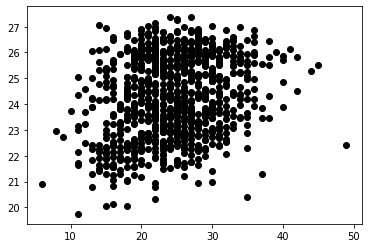

In [121]:
# Plot outputs
plt.scatter(vcrimes_per_day, y_predictions,  color='black')


plt.show()